In [1]:
# Read data RPBU

data <- read.table("data20102011-10min.txt", header = TRUE, sep = " ", quote = "\"")
data$datetime <- as.POSIXct(data$datetime, format = "%Y-%m-%d %H:%M:%S", tz = "UTC")
data <- data[order(data$datetime), ]
#data <- na.omit(data)
data$BG2windspeed <- with(data, approx(datetime, BG2windspeed, xout = datetime)$y)
data$BG2winddirection <- with(data, approx(datetime, BG2winddirection, xout = datetime)$y)

data$OS11waterlevel <- with(data, approx(datetime, OS11waterlevel, xout = datetime)$y)

data$OS4windspeed <- with(data, approx(datetime, OS4windspeed, xout = datetime)$y)
data$OS4winddirection <- with(data, approx(datetime, OS4winddirection, xout = datetime)$y)

data$RPBUwaterlevel <- with(data, approx(datetime, RPBUwaterlevel, xout = datetime)$y)

data$VRwaterlevel <- with(data, approx(datetime, VRwaterlevel, xout = datetime)$y)

head(data)
tail(data)

,BG2windspeed,BG2winddirection,OS11waterlevel,OS4windspeed,OS4winddirection,RPBUwaterlevel,VRwaterlevel,datetime
1153,102,273,44,108,279,32,84,2010-03-01 00:00:00
1154,102,275,57,122,276,43,107,2010-03-01 00:10:00
1155,100,276,72,110,274,54,133,2010-03-01 00:20:00
1156,107,273,92,118,275,70,160,2010-03-01 00:30:00
1157,113,271,116,127,276,91,188,2010-03-01 00:40:00
1158,118,273,142,123,276,115,213,2010-03-01 00:50:00


,BG2windspeed,BG2winddirection,OS11waterlevel,OS4windspeed,OS4winddirection,RPBUwaterlevel,VRwaterlevel,datetime
55435,80,191,89,79,199,74,122,2011-03-30 23:00:00
55436,84,197,100,79,202,86,127,2011-03-30 23:10:00
55437,83,200,107,76,202,95,130,2011-03-30 23:20:00
55438,76,201,113,79,203,102,131,2011-03-30 23:30:00
55439,72,199,115,74,204,107,131,2011-03-30 23:40:00
55440,74,202,116,75,205,110,130,2011-03-30 23:50:00


In [2]:
# Identify whether the wind direction is in the southwest range
data_wind <- data[, colnames(data) %in% c("BG2winddirection", "datetime")]
degree_window = 15
data_wind$to_northeast <- data_wind$BG2winddirection >= (45 - degree_window) & data$BG2winddirection <= (45 + degree_window)

run_list <- list()

curr_run <- 0
curr_start_datetime <- as.POSIXct("2010-03-01 00:00:00", format = "%Y-%m-%d %H:%M:%S", tz = "UTC")
longest_run <- 0
longest_run_start_datetime <- as.POSIXct("2010-03-01 00:00:00", format = "%Y-%m-%d %H:%M:%S", tz = "UTC")
longest_run_end_datetime <- as.POSIXct("2011-03-30 23:50:00", format = "%Y-%m-%d %H:%M:%S", tz = "UTC")
for (i in 1:nrow(data_wind)) {
    row <- data_wind[i, ]  # Extract the row as a data frame
    to_northeast <- row$to_northeast
    if(to_northeast) {
        if(curr_run == 0) {
            curr_start_datetime <- row$datetime
        }
        curr_run <- curr_run + 1
    }
    else {
        if(curr_run > longest_run) {
            longest_run <- curr_run
            longest_run_start_datetime <- curr_start_datetime
            longest_run_end_datetime <- data_wind[i-1, ]$datetime
        }
        curr_run <- 0
    }
    
    run_list <- append(run_list,curr_run)
}
if(curr_run > 0) {
    longest_run_end_datetime <- data_wind[-1, ]$datetime
}

data_wind$run <- unlist(run_list)

In [3]:
print(longest_run)
print(paste("time (hours):", 1/6*longest_run))
print(longest_run_start_datetime)
print(longest_run_end_datetime)

[1] 144
[1] "time (hours): 24"
[1] "2011-03-01 00:30:00 UTC"
[1] "2011-03-02 00:20:00 UTC"


In [4]:
# Filter out date period and filter out columns we do not longer need
data_wind_filtered <- data[data$datetime >= longest_run_start_datetime & data$datetime <= longest_run_end_datetime, ]
data_filtered <- data_wind_filtered[, colnames(data_wind_filtered) %in% c("OS11waterlevel", "VRwaterlevel", "RPBUwaterlevel","datetime")]
head(data_filtered)
tail(data_filtered)

,OS11waterlevel,RPBUwaterlevel,VRwaterlevel,datetime
1300,69,74,69,2011-03-01 00:30:00
1301,65,72,63,2011-03-01 00:40:00
1302,60,70,56,2011-03-01 00:50:00
1303,56,67,49,2011-03-01 01:00:00
1304,50,64,41,2011-03-01 01:10:00
1305,44,60,33,2011-03-01 01:20:00


,OS11waterlevel,RPBUwaterlevel,VRwaterlevel,datetime
1438,50,34,94,2011-03-01 23:30:00
1439,63,46,103,2011-03-01 23:40:00
1440,74,60,109,2011-03-01 23:50:00
3169,82,72,113,2011-03-02 00:00:00
3170,89,82,115,2011-03-02 00:10:00
3171,93,87,115,2011-03-02 00:20:00


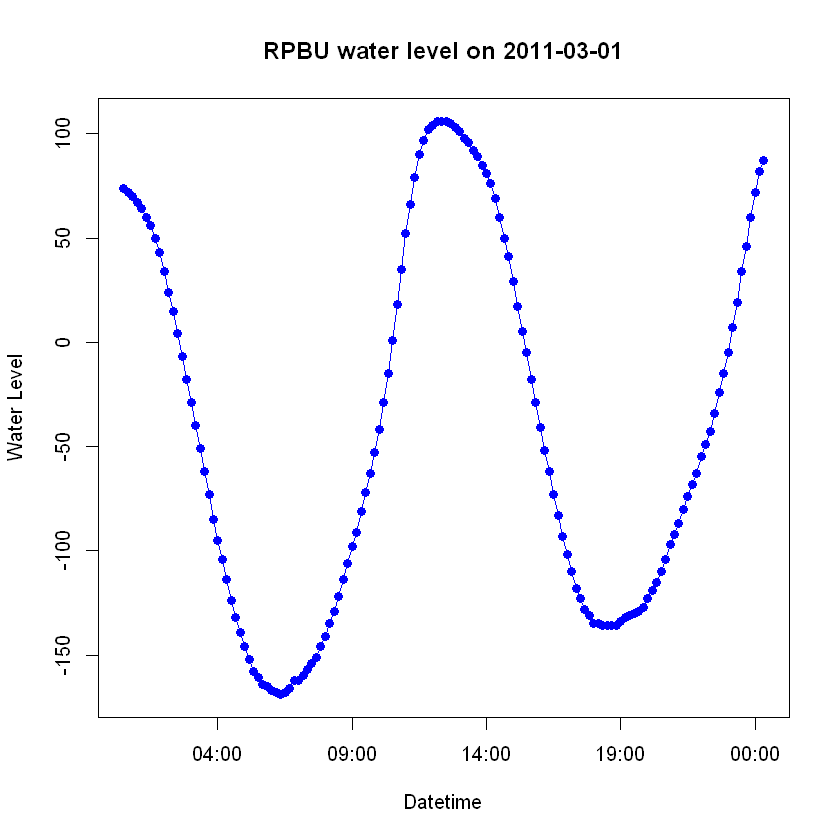

In [6]:
# Plot simple stuff

plot(data_filtered$datetime, data_filtered$RPBUwaterlevel, type = "o", col = "blue", pch = 16, xlab = "Datetime", ylab = "Water Level",
     main = paste("RPBU water level on","2011-03-01"))

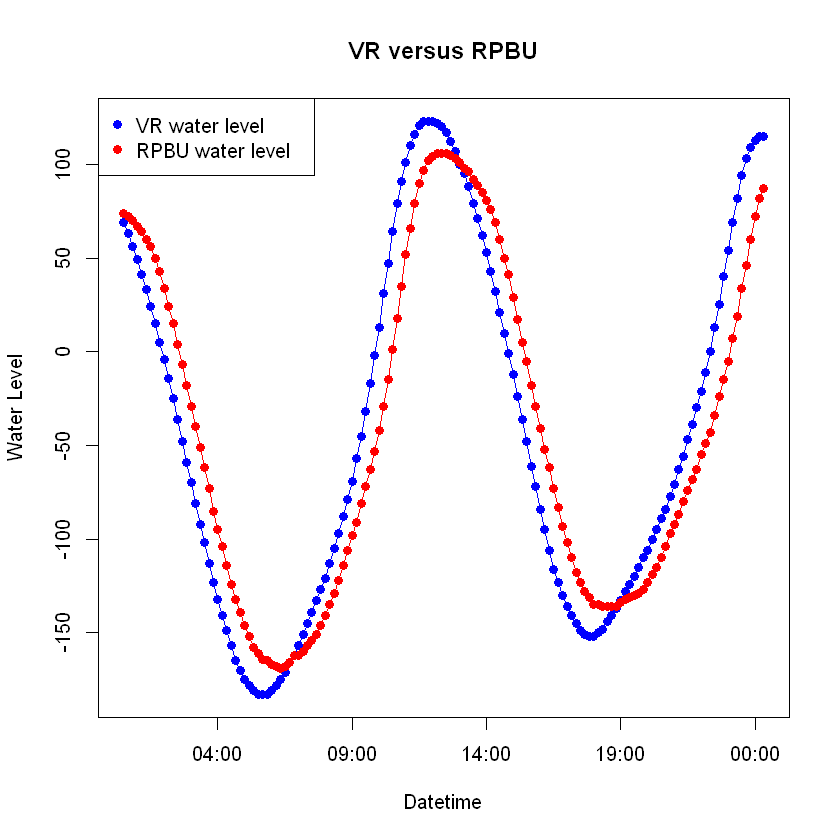

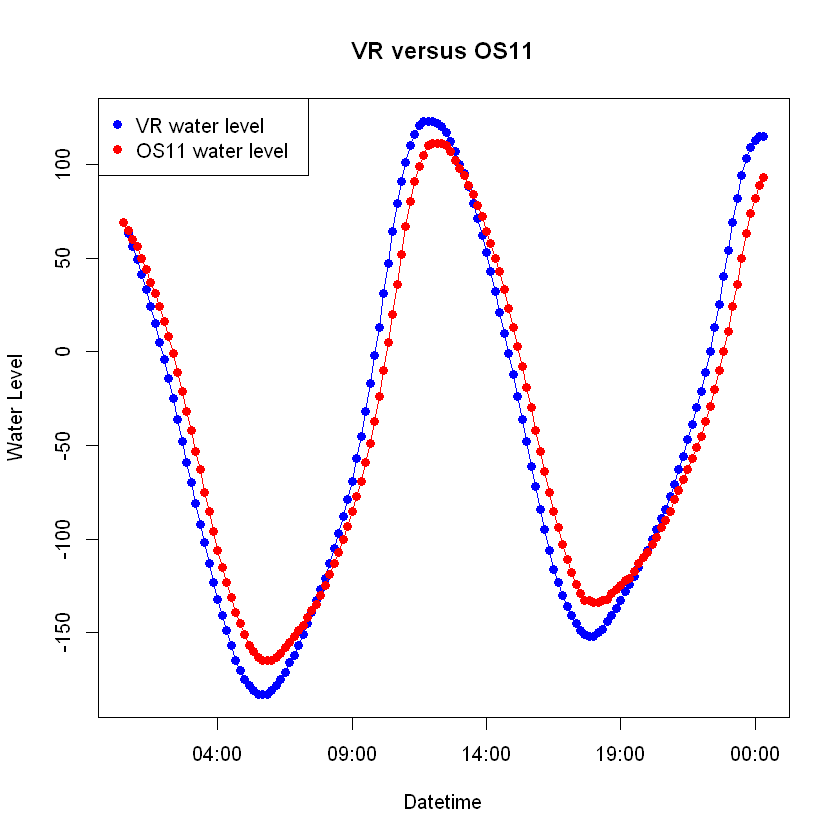

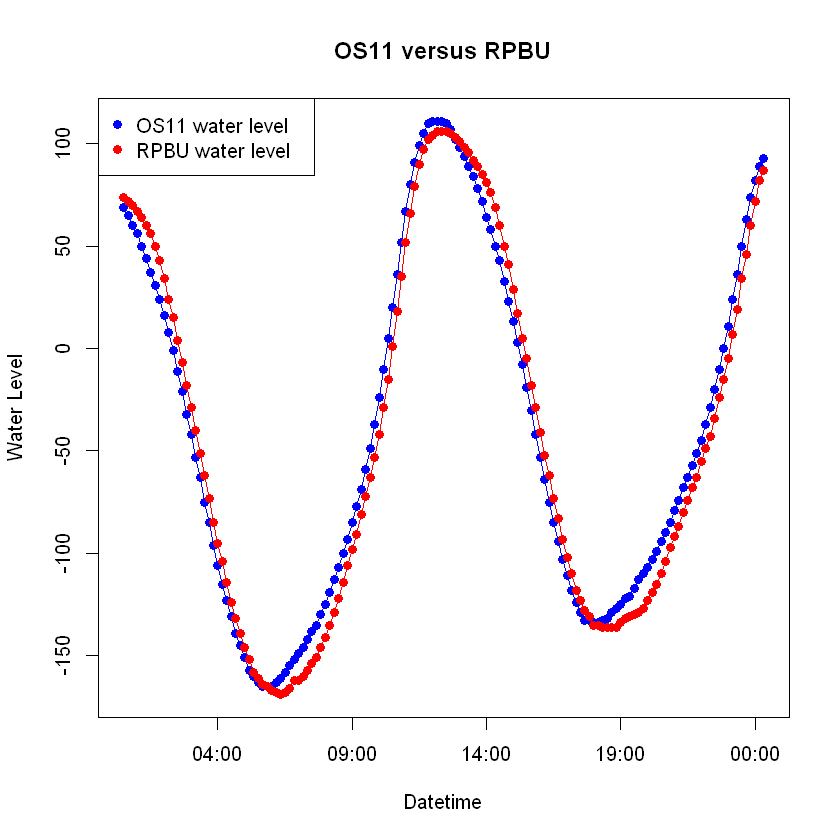

In [7]:
# Plotting water values to show offset in data; Exploratory data

# VR vs RPBU
y_range <- range(data_filtered$VRwaterlevel, data_filtered$RPBUwaterlevel)
plot(data_filtered$datetime, data_filtered$VRwaterlevel, type = "o", col = "blue", pch = 16, xlab = "Datetime", ylab = "Water Level",
     main = "VR versus RPBU", ylim = y_range)
lines(data_filtered$datetime, data_filtered$RPBUwaterlevel, type = "o", col = "red", pch = 16)
legend("topleft", legend = c("VR water level", "RPBU water level"), col = c("blue", "red"), pch = 16)

# OS11 vs VR 
y_range <- range(data_filtered$OS11waterlevel, data_filtered$VRwaterlevel)
plot(data_filtered$datetime, data_filtered$VRwaterlevel, type = "o", col = "blue", pch = 16, xlab = "Datetime", ylab = "Water Level",
     main = "VR versus OS11", ylim = y_range)
lines(data_filtered$datetime, data_filtered$OS11waterlevel, type = "o", col = "red", pch = 16)
legend("topleft", legend = c("VR water level", "OS11 water level"), col = c("blue", "red"), pch = 16)

# OS11 vs RPBU
y_range <- range(data_filtered$OS11waterlevel, data_filtered$RPBUwaterlevel)
plot(data_filtered$datetime, data_filtered$OS11waterlevel, type = "o", col = "blue", pch = 16, xlab = "Datetime", ylab = "Water Level",
     main = "OS11 versus RPBU", ylim = y_range)
lines(data_filtered$datetime, data_filtered$RPBUwaterlevel, type = "o", col = "red", pch = 16)
legend("topleft", legend = c("OS11 water level", "RPBU water level"), col = c("blue", "red"), pch = 16)

In [8]:
# Create time variable t for ease of work
data_filtered$t <- as.integer(data_filtered$datetime)
offset_t <- min(data_filtered$t)
data_filtered$t <- data_filtered$t - offset_t

In [9]:
# Define complicated ahh interpolation function for the water level so we have a continuous function to use nls

max_t_val <- max(data_filtered$t)
step_t <- 600 # 10 minutes per data row

interpolate_water_level <- function(buoy_name, t) { 
    # This piece of shit is needed because the people that made this language are autistic drunk maggots and I hope for the sake of human evolution that they were born infertile
    if(length(t) > 1) {
        return(sapply(t, interpolate_water_level, buoy_name = buoy_name))
    }
    
    if(t < 0) {
        t = 0
    }
    else if(t > max_t_val) {
        t = max_t_val
    }

    t_val_prev <- floor(t/step_t)*step_t # Floors t to nearest 600 multiple
    t_val_next <- ceiling(t/step_t)*step_t # Ceils t to nearest 600 multiple
    
    water_level_prev <- 0
    water_level_next <- 0
    
    if(buoy_name == "OS11") {
        water_level_prev <- data_filtered[data_filtered$t == t_val_prev, ]$OS11waterlevel
        water_level_next <- data_filtered[data_filtered$t == t_val_next, ]$OS11waterlevel
    }
    else if(buoy_name == "VR") {
        water_level_prev <- data_filtered[data_filtered$t == t_val_prev, ]$VRwaterlevel
        water_level_next <- data_filtered[data_filtered$t == t_val_next, ]$VRwaterlevel
    }
    else if(buoy_name == "RPBU") {
        water_level_prev <- data_filtered[data_filtered$t == t_val_prev, ]$RPBUwaterlevel
        water_level_next <- data_filtered[data_filtered$t == t_val_next, ]$RPBUwaterlevel
    }
    else {
        stop(paste("Param buoy_name is invalid:",buoy_name))
    }
    
    t_param <- (t %% step_t)/600 # Percentage that t is between 0 and 600 (in mod 600)
    
    return(water_level_prev*(1 - t_param) + water_level_next*(t_param))
}

In [10]:
# Test zut

model_VR_RPBU <- nls(VRwaterlevel ~ amplitude * interpolate_water_level("RPBU", t + offset), 
                     data = data_filtered,
                     start = list(amplitude=1,offset=23*60)) # Default 23 minute offset

summary(model_VR_RPBU)

model_VR_OS11 <- nls(VRwaterlevel ~ amplitude * interpolate_water_level("OS11", t + offset), 
                     data = data_filtered,
                     start = list(amplitude=1,offset=17*60)) # Default 17 minute offset

summary(model_VR_OS11)

model_OS11_RPBU <- nls(OS11waterlevel ~ amplitude * interpolate_water_level("RPBU", t + offset), 
                     data = data_filtered,
                     start = list(amplitude=1,offset=6*60)) # Default 6 minute offset

summary(model_OS11_RPBU)


Formula: VRwaterlevel ~ amplitude * interpolate_water_level("RPBU", t + 
    offset)

Parameters:
           Estimate Std. Error t value Pr(>|t|)    
amplitude 1.067e+00  5.240e-03  203.71   <2e-16 ***
offset    2.314e+03  3.618e+01   63.95   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.215 on 142 degrees of freedom

Number of iterations to convergence: 3 
Achieved convergence tolerance: 6.917e-08



Formula: VRwaterlevel ~ amplitude * interpolate_water_level("OS11", t + 
    offset)

Parameters:
           Estimate Std. Error t value Pr(>|t|)    
amplitude 1.105e+00  3.873e-03  285.37   <2e-16 ***
offset    1.431e+03  2.574e+01   55.62   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.443 on 142 degrees of freedom

Number of iterations to convergence: 3 
Achieved convergence tolerance: 6.117e-08



Formula: OS11waterlevel ~ amplitude * interpolate_water_level("RPBU", 
    t + offset)

Parameters:
           Estimate Std. Error t value Pr(>|t|)    
amplitude 9.655e-01  3.082e-03   313.3   <2e-16 ***
offset    8.769e+02  2.344e+01    37.4   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.648 on 142 degrees of freedom

Number of iterations to convergence: 3 
Achieved convergence tolerance: 4.408e-08


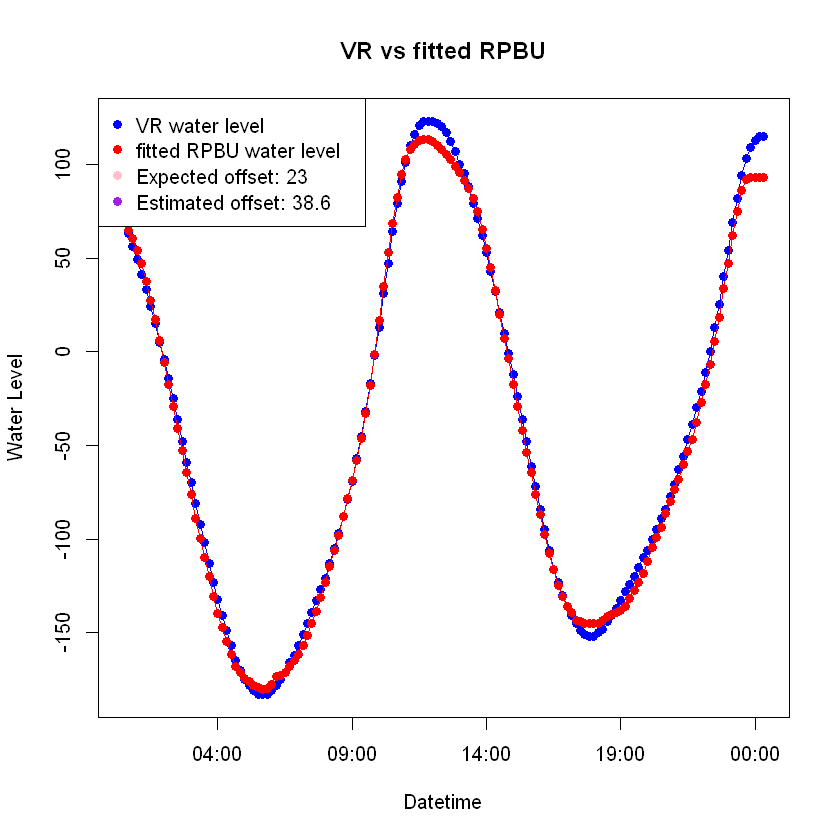

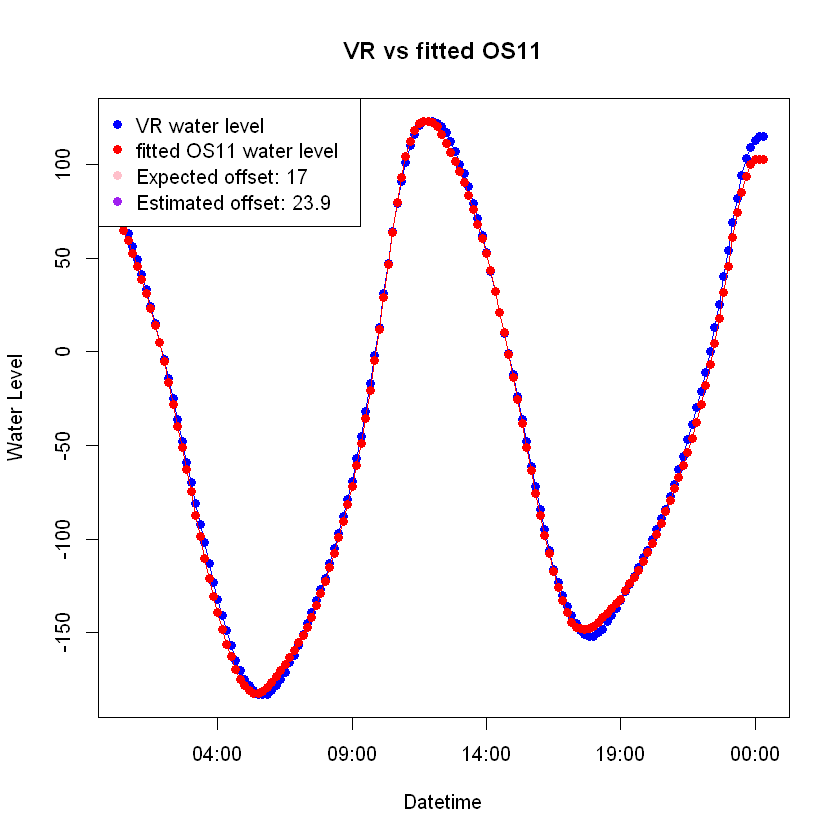

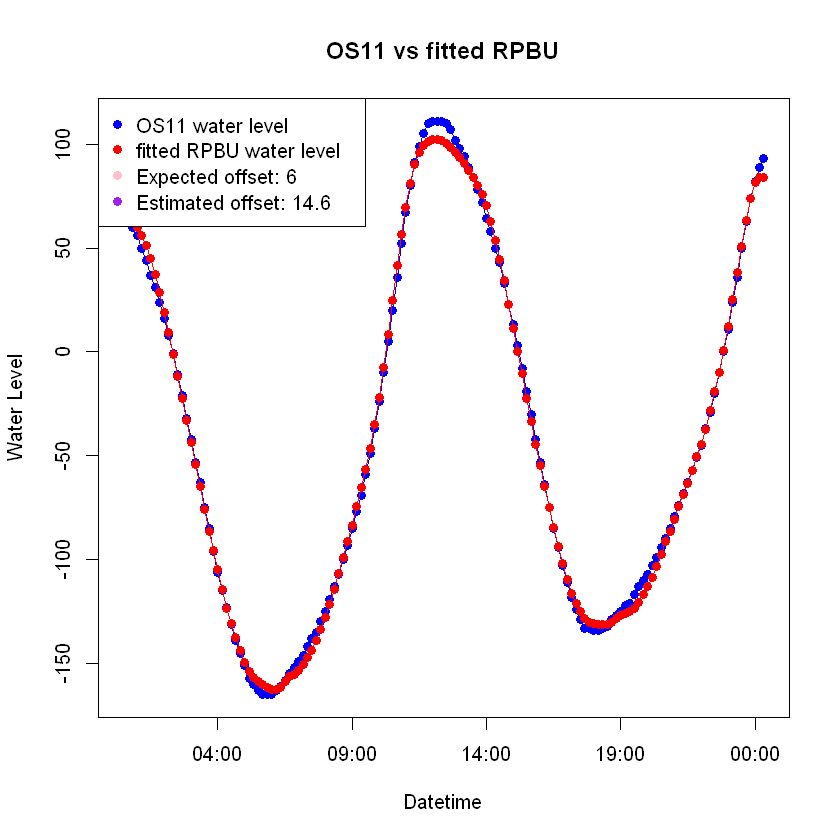

In [11]:
# Putting predictions in the table
data_filtered$RPBU_fitted_to_VR <- predict(model_VR_RPBU, data_filtered)
data_filtered$OS11_fitted_to_VR <- predict(model_VR_OS11, data_filtered)
data_filtered$RPBU_fitted_to_OS11 <- predict(model_OS11_RPBU, data_filtered)

coef_VR_RPBU <- coef(model_VR_RPBU)["offset"]
coef_VR_OS11 <- coef(model_VR_OS11)["offset"]
coef_OS11_RPBU <- coef(model_OS11_RPBU)["offset"]

# VR vs Fitted RPBU
plot(data_filtered$datetime, data_filtered$VRwaterlevel, type = "o", col = "blue", pch = 16, xlab = "Datetime", ylab = "Water Level",
     main = "VR vs fitted RPBU")
lines(data_filtered$datetime, data_filtered$RPBU_fitted_to_VR, type = "o", col = "red", pch = 16)
legend("topleft", legend = c("VR water level", "fitted RPBU water level", paste("Expected offset:",23), paste("Estimated offset:",round(coef_VR_RPBU/60, digits = 1))), 
       col = c("blue", "red", "pink", "purple"), pch = 16)

# VR vs fitted OS11
plot(data_filtered$datetime, data_filtered$VRwaterlevel, type = "o", col = "blue", pch = 16, xlab = "Datetime", ylab = "Water Level",
     main = "VR vs fitted OS11")
lines(data_filtered$datetime, data_filtered$OS11_fitted_to_VR, type = "o", col = "red", pch = 16)
legend("topleft", legend = c("VR water level", "fitted OS11 water level", paste("Expected offset:",17), paste("Estimated offset:",round(coef_VR_OS11/60,digits = 1))), 
       col = c("blue", "red", "pink", "purple"), pch = 16)

# OS11 vs fitted RPBU
plot(data_filtered$datetime, data_filtered$OS11waterlevel, type = "o", col = "blue", pch = 16, xlab = "Datetime", ylab = "Water Level",
     main = "OS11 vs fitted RPBU")
lines(data_filtered$datetime, data_filtered$RPBU_fitted_to_OS11, type = "o", col = "red", pch = 16)
legend("topleft", 
       legend = c("OS11 water level", "fitted RPBU water level", paste("Expected offset:",6), paste("Estimated offset:",round(coef_OS11_RPBU/60,digits = 1))), 
       col = c("blue", "red", "pink", "purple"), pch = 16)